In [2]:
!pip install matplotlib

  Using cached matplotlib-3.5.0-cp38-cp38-macosx_11_0_arm64.whl (7.1 MB)
     |████████████████████████████████| 880 kB 868 kB/s            
     |████████████████████████████████| 2.8 MB 684 kB/s            
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached setuptools_scm-6.3.2-py3-none-any.whl (33 kB)
  Using cached kiwisolver-1.3.2-cp38-cp38-macosx_11_0_arm64.whl (59 kB)
  Using cached tomli-1.2.2-py3-none-any.whl (12 kB)


In [20]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size':16})

Dataset to manage vector to vector data 

In [34]:
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self,input_data, output_data): 
        super(VectorialDataset,self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
        
    def __len__(self): 
        return self.input_data.shape[0]
    
    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], 
                  self.output_data[idx, :])
        return sample
    

Linear layer

In [29]:
class LinearModel(nn.Module): 
    def __init__(self, input_dim, output_dim): 
        
        super(LinearModel, self).__init__()
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)
        
    def forward(self, x): 
        out = self.linear(x)
        return out
    
    def reset(self): 
        self.linear.reset_parameters()
    
    

### Raw dataset

$x \in \mathbb{R}^{input\_dim}$ and $y \in \mathbb{R}^{output\_dim}$ 

In [6]:
input_dim = 1
output_dim =1 

A = 2 * np.random.rand(output_dim, input_dim) -1
b = 2 * np.random.rand(output_dim) - 1 
true_model = lambda x : A @ x + b

We get a training set by randomly sampling a noisy observations

$$x_i \sim U([-1, 1])$$
$$y_i = Ax_i + b + v_i$$


In [9]:
n_train = 1000
noise_level = 0.04

# generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

#Add some noise 
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

visualize the data

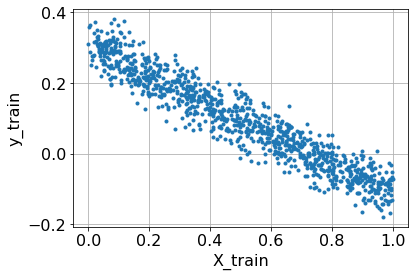

In [15]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, ".")
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

Pytorch Dataset

In [36]:

training_set = VectorialDataset(input_data=X_train, output_data=y_train)

In [37]:
len(training_set)

1000

In [38]:
training_set[10:12]

(tensor([[0.1474],
         [0.4171]]),
 tensor([[0.2828],
         [0.0937]]))

Pytorch Dataloader

In [39]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=batch_size, 
                                           shuffle = True)

In [41]:
for idx, batch in enumerate(train_loader): 
    print(f"Batch n: {idx + 1} input size={batch[0].shape}, output size ={batch[1].shape}")

Batch n: 1 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 2 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 3 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 4 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 5 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 6 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 7 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 8 input size=torch.Size([120, 1]), output size =torch.Size([120, 1])
Batch n: 9 input size=torch.Size([40, 1]), output size =torch.Size([40, 1])


**Model**

We will implement a linear model


In [43]:
model = LinearModel(input_dim, output_dim)

Model Inspection

In [45]:
print(model)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [46]:
list(model.parameters())

[Parameter containing:
 tensor([[0.6787]], requires_grad=True),
 Parameter containing:
 tensor([-0.3365], requires_grad=True)]

In [47]:
model.linear.weight

Parameter containing:
tensor([[0.6787]], requires_grad=True)

In [48]:
model.linear.bias

Parameter containing:
tensor([-0.3365], requires_grad=True)

The forward method 

In [49]:
x = torch.randn(5, input_dim) 
model.forward(x)

tensor([[-1.0538],
        [-1.9786],
        [-0.8695],
        [ 0.6750],
        [-0.7677]], grad_fn=<AddmmBackward0>)

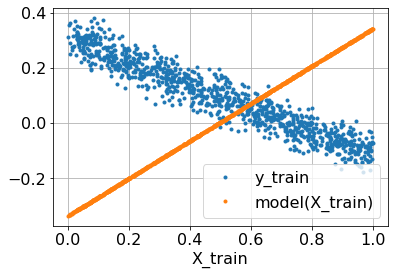

In [56]:
if input_dim == output_dim == 1: 
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    y_hat = model.forward(training_set.input_data).detach().numpy()
    ax.plot(training_set.input_data, y_hat, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train','model(X_train)'])

Losses
The MSE loss is 

$$L(y,y') = ||y - y'||_2^2$$


In [57]:
import torch.nn as nn 
loss_fun = nn.MSELoss(reduction='mean')

In [60]:
x = torch.tensor(np.array([1,2,1]).astype('f'))
z = torch.tensor(np.array([0,0,0]).astype('f'))
loss_fun(x,z)

tensor(2.)

IndexError: list index out of range

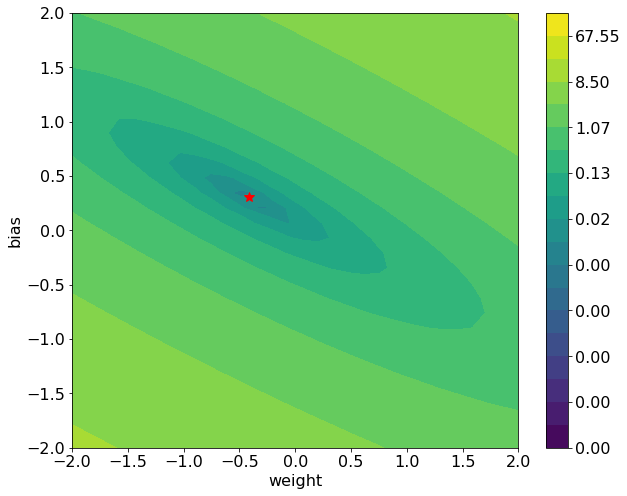

In [61]:
if input_dim == output_dim == 1:

    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(A, b)'])
    
    ax.grid(True)    

In [62]:
if input_dim == output_dim == 1:

    num_iter = 200
    lr = 0.5 # 0.01

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

IndexError: list index out of range

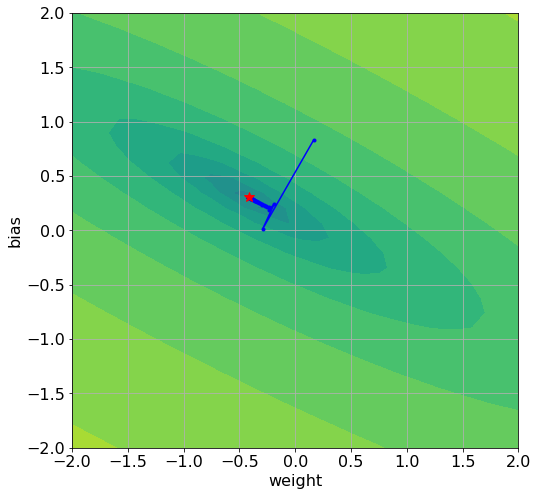

In [63]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    ax.legend(['optim', '(A, b)'])